In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import sys
root_path = '../'
sys.path.insert(0, root_path)

import lightning as L
from natsort import natsorted

from run import *
from utils import *

Load checkpoints

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
run_name = "dhneula5"
root_dir = os.path.join("../results", "DPT_3", run_name, "checkpoints")

# run_name = "results/DPT_3/3ylpjbd0/checkpoints"
checkpoint = natsorted(os.listdir(root_dir))[-1]
checkpoint_file = os.path.join(root_dir, checkpoint)

model = DPTSolver.load_from_checkpoint(checkpoint_file).cpu()

In [5]:
checkpoint_file

'../results/DPT_3/dhneula5/checkpoints/epoch=199.ckpt'

Load the offline datasets used for train and validation as well as online dataset with the same problems that were in validation.

In [17]:
%cd ..

config = model.config
config["batch_size"] = 2048
config["problem_params"]["use_problems"] = 250000
datamodule = ProblemDataModule(config)
datamodule.setup()

train_offline_dataset = datamodule.train_dataloader().dataset
val_offline_dataset = datamodule.val_dataloader().dataset
val_online_dataset = datamodule.test_dataloader().dataset

%cd notebooks

/home/jovyan/shares/SR004.nfs2/kurkin/GreyBoxDPTOptimizer
/home/jovyan/shares/SR004.nfs2/kurkin/GreyBoxDPTOptimizer/notebooks


In [18]:
def online_inference(model):
    tester = L.Trainer(logger=False, precision=config["precision"])
    test_dataloader = datamodule.test_dataloader()

    # check out two strategies of online inference:
    # - where a predicted action is the argmax of a predicted distribution 
    # - where a predicted action is sampled with temperature = 1 from a predicted distribution 
    hparams = [
        {"do_sample": False, "temperature": 0.0},
        {"do_sample": True, "temperature": 1.0},
    ]
    results_list = []
    for i, hparam in enumerate(hparams):
        model.config["do_sample"] = hparam["do_sample"]
        model.config["temperature"] = hparam["temperature"]
        best_results = tester.test(model=model, dataloaders=test_dataloader)[0]
        results = model.save_results
        results = {
            "MAE(best x, x*)": results["best_x_mae"].cpu().tolist(),
            "MAE(best y, y*)": results["best_y_mae"].cpu().tolist(),
            "MAE(all x, x*)": results["all_x_mae"].cpu().tolist(),
            "MAE(all y, y*)": results["all_y_mae"].cpu().tolist(),
        }
        results_list.append(hparam | results)
    return results_list

In [12]:
len(val_online_dataset)

10000

In [ ]:
results_list = online_inference(model)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

In [15]:
%config InlineBackend.figure_format='retina'

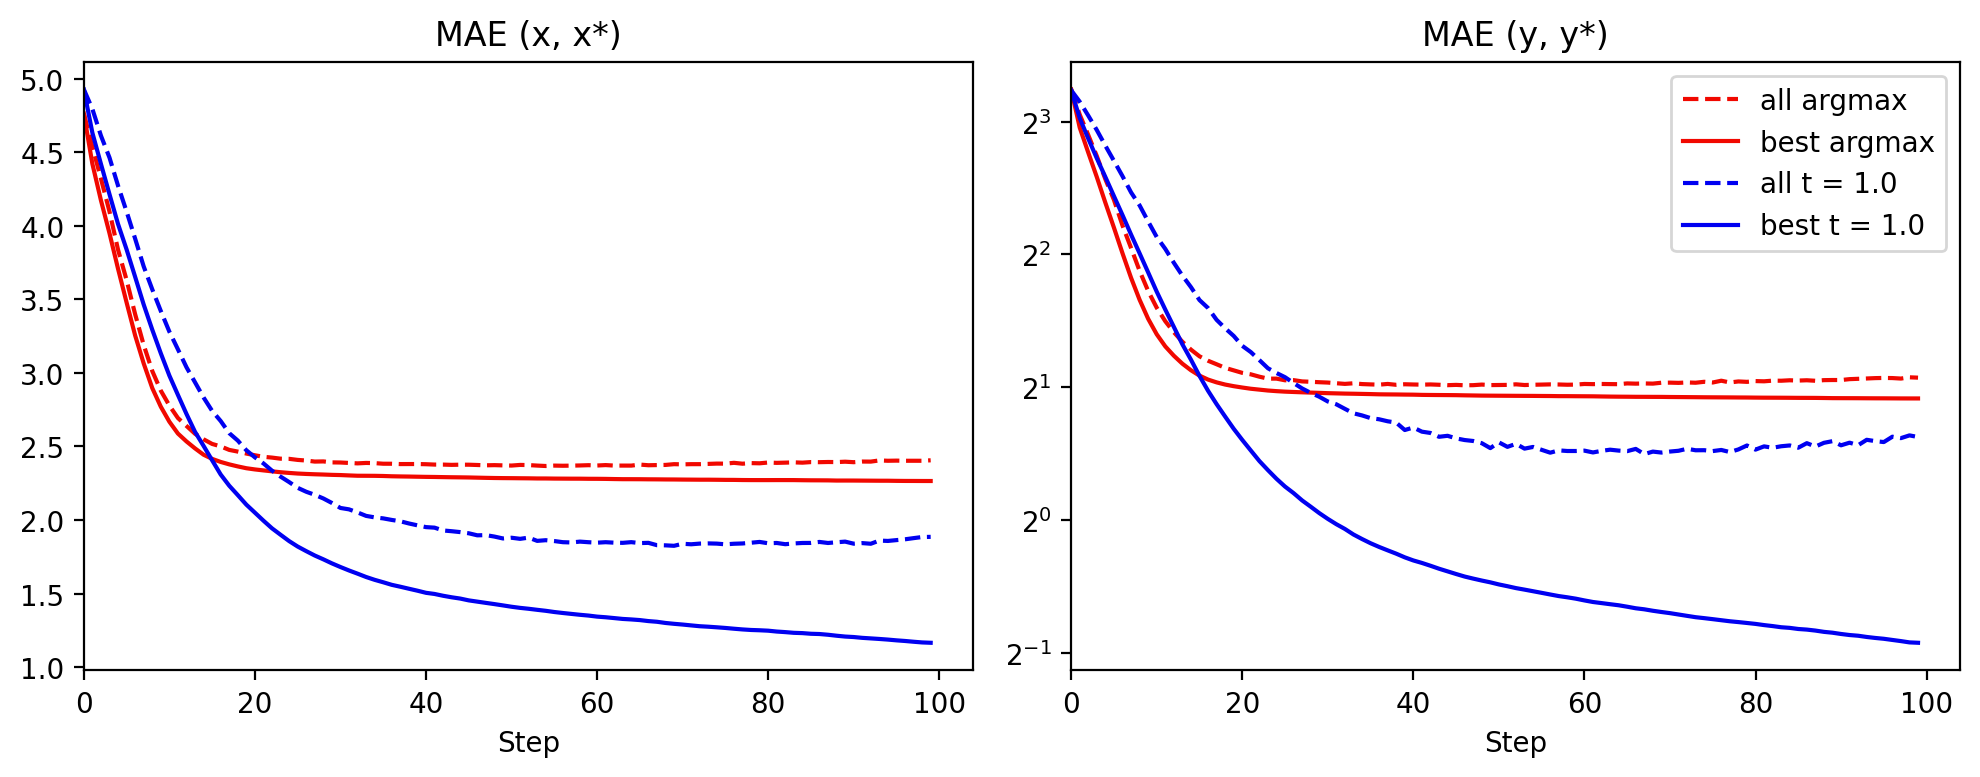

In [16]:
from matplotlib import colormaps as cm

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('MAE (x, x*)')
axes[1].set_title('MAE (y, y*)')

cmap = cm.get_cmap('jet')
color_list = [cmap(c) for c in np.linspace(0.1, 0.9, len(results_list))[::-1]]
for results, c in zip(results_list, color_list):
    label = f't = {results["temperature"]}' if results["do_sample"] else 'argmax'
    axes[0].plot(results["MAE(all x, x*)"], c=c, linestyle='--')
    axes[1].plot(results["MAE(all y, y*)"], c=c, linestyle='--', label=f'all {label}')
    axes[0].plot(results["MAE(best x, x*)"], c=c,)
    axes[1].plot(results["MAE(best y, y*)"], c=c, label=f'best {label}')

for ax in axes:
    ax.set_xlim(0, None)
    ax.set_xlabel('Step')
axes[1].set_yscale('log', base=2)
axes[1].legend(loc=1)

plt.tight_layout()
plt.show()

An example of offline mode for a problem from the train dataset.

In [9]:
sample, outputs, predictions, metrics = run(model, val_offline_dataset[0])
print_sample(sample, predictions)
print_metrics(metrics)

query_state:
     [0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1.155209]
context:
     {2}
     [0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1.226108] -> 0 -> [1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 6.293175] reward: 2.1487326622009277 {0}
     [0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 8.500586] -> 0 -> [1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 10.727859] reward: 4.029688835144043 {2}
     [0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 8.155829] -> 2 -> [0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 6.003711] reward: 2.1069021224975586 {2}
     [1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 4.449362] -> 2 -> [1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 4.089136] reward: 1.535111904144287 {2}
     [0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 5.786327] -> 6 -> [0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 6.488286] reward: 2.439664840698242 {2}
     [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 14.791676] -> 0 -> [0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 11.566188] reward: 4.3396077156066895 {5}
     [1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 10.514808] -> 5 -> [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 12.211260] reward: 4.665110111236572 {5}
     [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 11.1

An example of online mode for a problem from the validation dataset.

In [11]:
# one may choose a strategy
# model.config["do_sample"] = False
# model.config["temperature"] = 0.0
model.config["do_sample"] = False
model.config["temperature"] = 1.0

sample, outputs, predictions, metrics = run(model, val_online_dataset[0], n_steps=50)
print_sample(sample, print_ta=True, print_fm=True)
print_metrics(metrics)

query_state:
     [0, 0, 1, 0, 1, 0, 1, 0, 0, 1, -2.002459]
context:
     [0, 0, 1, 0, 1, 0, 1, 0, 0, 1, -2.002459] -> 1 -> [0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0.894225] reward: 0.5
     [0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0.894225] -> 1 -> [0, 0, 1, 0, 1, 0, 1, 0, 0, 1, -2.002459] reward: 1.74797523021698
     [0, 0, 1, 0, 1, 0, 1, 0, 0, 1, -2.002459] -> 7 -> [0, 0, 1, 0, 1, 0, 1, 1, 0, 1, -6.601516] reward: 1.237653136253357
     [0, 0, 1, 0, 1, 0, 1, 1, 0, 1, -6.601516] -> 0 -> [1, 0, 1, 0, 1, 0, 1, 1, 0, 1, -9.386106] reward: 0.3430200517177582
     [1, 0, 1, 0, 1, 0, 1, 1, 0, 1, -9.386106] -> 3 -> [1, 0, 1, 1, 1, 0, 1, 1, 0, 1, -8.854720] reward: 0.35480862855911255
     [1, 0, 1, 1, 1, 0, 1, 1, 0, 1, -8.854720] -> 8 -> [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, -8.372840] reward: 0.39138615131378174
     [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, -8.372840] -> 8 -> [1, 0, 1, 1, 1, 0, 1, 1, 0, 1, -8.854720] reward: 0.5283070802688599
     [1, 0, 1, 1, 1, 0, 1, 1, 0, 1, -8.854720] -> 5 -> [1, 0, 1, 1, 1, 1, 1, 1, 0

In [13]:
outputs.shape

torch.Size([50, 11])

In [1]:
from tqdm.auto import tqdm

def online_inference_dataset(model, dataset, idx):
    hparams = [
        {"do_sample": False, "temperature": 0.0},
        {"do_sample": True, "temperature": 1.0},
    ]
    results_list = []
    for i, hparam in enumerate(hparams):
        model.config["do_sample"] = hparam["do_sample"]
        model.config["temperature"] = hparam["temperature"]
        all_results = {"x_mae": [], "y_mae": []}
        for i in tqdm(idx):
            with torch.inference_mode():
                _, _, _, metrics = run(model, dataset[i], n_steps=100)
            for k in metrics:
                all_results[k].append(metrics[k].detach().cpu().numpy())
        for k in metrics:
                all_results[k] = np.vstack(all_results[k]).mean(0)
        all_results = {
            "MAE(all x, x*)": all_results["x_mae"],
            "MAE(all y, y*)": all_results["y_mae"]
        }
        results_list.append(hparam | all_results)
    return results_list

In [2]:
res = online_inference_dataset(model, val_online_dataset, list(range(1000)))

NameError: name 'model' is not defined

In [38]:
%config InlineBackend.figure_format='retina'

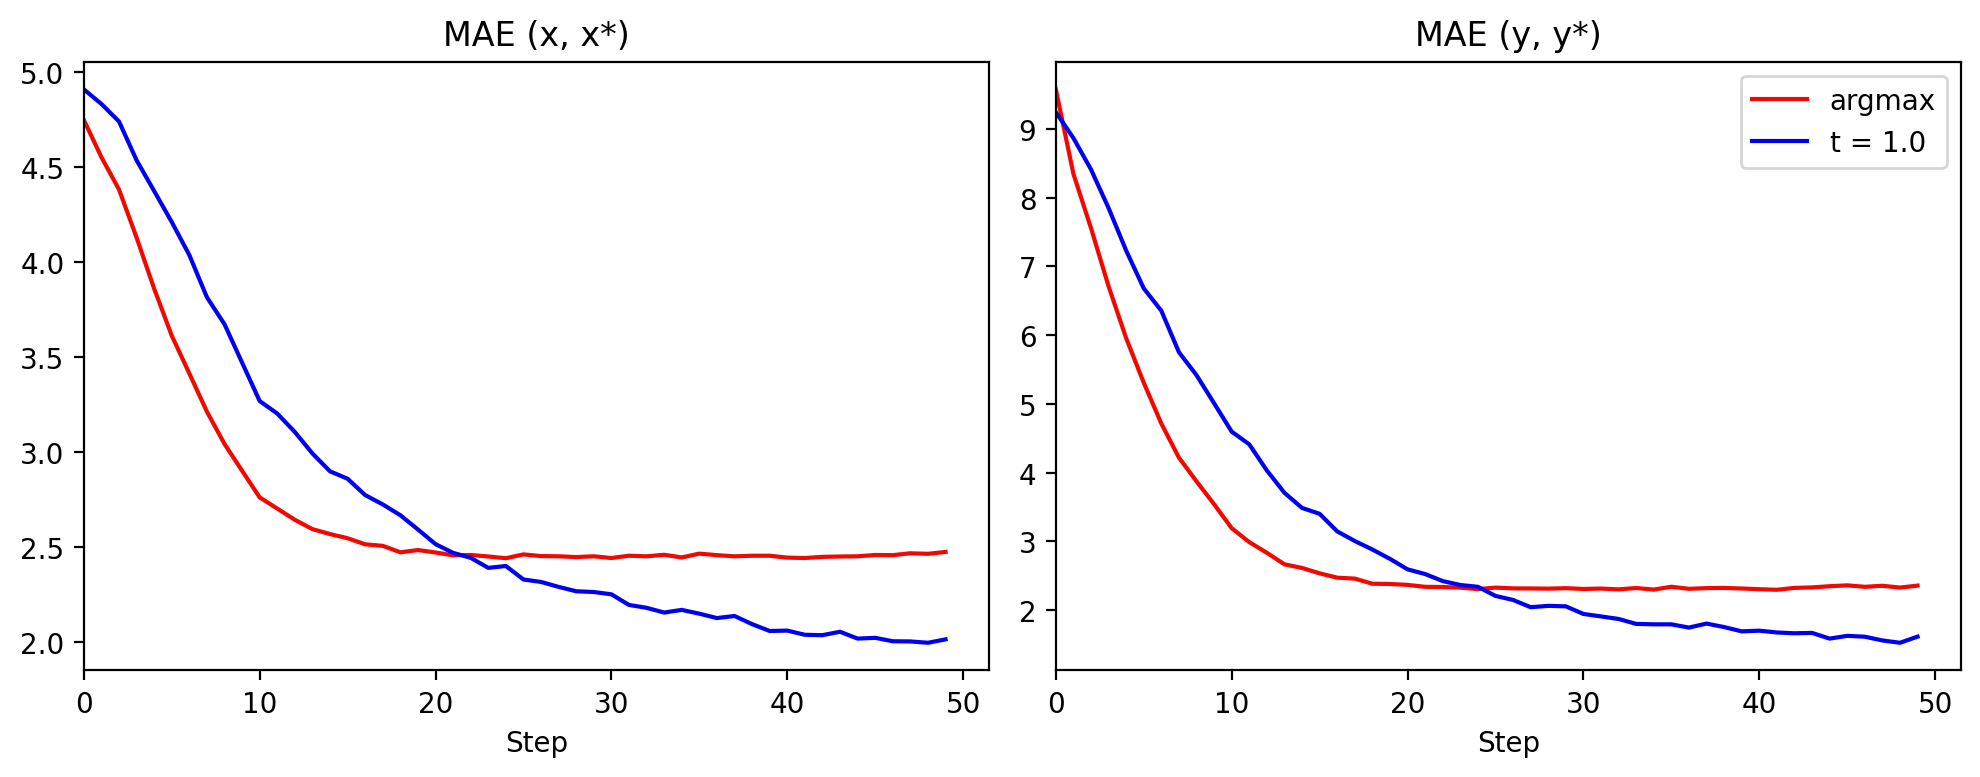

In [39]:
from matplotlib import colormaps as cm

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('MAE (x, x*)')
axes[1].set_title('MAE (y, y*)')

cmap = cm.get_cmap('jet')
color_list = [cmap(c) for c in np.linspace(0.1, 0.9, len(res))[::-1]]
for results, c in zip(res, color_list):
    label = f't = {results["temperature"]}' if results["do_sample"] else 'argmax'
    axes[0].plot(results["MAE(all x, x*)"], c=c)
    axes[1].plot(results["MAE(all y, y*)"], c=c, label=f'{label}')
    # print(label)
    # print(f'MAE(best x, x*) = {results["MAE(best x, x*)"]}')
    # print(f'MAE(best y, y*) = {results["MAE(best y, y*)"]}')
    # print()

for ax in axes:
    ax.set_xlim(0, None)
    ax.set_xlabel('Step')
# axes[1].set_yscale('log')
axes[1].legend(loc=1)

plt.tight_layout()
plt.show()